In [7]:
%matplotlib inline
import os,sys,inspect
import datetime
import subprocess
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
#sys.path.insert(0,parentdir)
sys.path.insert(0,parentdir+"/Ampel-T0-ref-master/src") 

In [8]:
downloadfile=False

### Download the data

In [9]:
import urllib.request

In [10]:
alert_file="ztf_public_%s.tar.gz" %(datetime.date.today().strftime("%Y%m%d"))
alert_file="ztf_public_20180909"
dataurl = "https://ztf.uw.edu/alerts/public/%s" %alert_file
if downloadfile:
    print('Dowloading %s ...' %dataurl)
    urllib.request.urlretrieve(dataurl,"../%s" %alert_file)
alertfilepath="../%s" %alert_file
print('DONE')

DONE


In [11]:
command = "pkill mongod"
command_list = command.split()
p = subprocess.Popen(command_list)
p.wait()

command = "mongod --dbpath /home/mnievas/ZTF/DB/"
command_list = command.split()
p = subprocess.Popen(command_list)

### VERITAS channels.py

In [12]:
from extcats.CatalogPusher import df_to_dictlist_force_types
import pymongo
import os, sys
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import numpy as np

data_dir = "../Catalogs/"

def geoJSON_modifier(srcdict):
    ra=srcdict['RAJ2000'] if srcdict['RAJ2000']<180. else srcdict['RAJ2000']-360.
    srcdict['pos']={
            'type': 'Point', 
            'coordinates': [ra, srcdict['DEJ2000']]
                    }
    # decode raw str
    for kk in ['GAMMAASSOC', 'ASSOC', 'CLASS', 'ID']:
        if kk in srcdict.keys():
            srcdict[kk] = srcdict[kk].decode("utf-8")
    return srcdict

def convert_str_deg(string,hours=False):
    """ Take as input a string of the form hh mm ss or dd mm ss and convert it to float """
    _deg,_min,_sec = [float(k) for k in string.split(" ")]
    if _deg==0:
        _sign = 1
    else:
        _sign = _deg/abs(_deg)
    _floatdeg = _sign*(hours*(14)+1)*(abs(_deg)+_min/60.+_sec/3600.)
    return(_floatdeg)


#cols = tuple(name for name in self.colnames if len(self[name].shape) <= 1)
#        self = self[cols]


def push_2fav():
    
    # create database
    c = pymongo.MongoClient()
    
    if '2FAV' in c.list_database_names():
        c.drop_database('2FAV')
    
    db = c['2FAV']
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(os.path.join(data_dir, '2fav_v10.fits'), hdu = 1)
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Matteo Giomi",
                                "email" : "matteo.giomi@desy.de",
                                "description" : "the gamma-ray connection",
                                "ref" : "xxx"
                            }
                            )
    print ("done with 2FAV")

def push_fermi_cat(dbname, fits):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(fits, hdu = 1)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Matteo Giomi",
                                "email" : "matteo.giomi@desy.de",
                                "description" : "the gamma-ray connection",
                                "ref" : "xxx"
                            }
                            )
    print ("done with %s"%dbname)

def push_2whsp_cat(dbname, csv):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(csv)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [convert_str_deg(k,hours=True) for k in tab["R.A."]]
    tab['DEJ2000'] = [convert_str_deg(k,hours=False) for k in tab["Dec"]]
    tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['γ-ray counterpart']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['Source name']]
    tab['ID'] = [str(k).encode("utf-8") for k in tab['id']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "2wshp",
                                "ref" : "xxx"
                            }
                            )
    print ("done with %s"%dbname)
    
def push_bepposaxblazars_cat(dbname, csv):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(csv)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [convert_str_deg(k,hours=True) for k in tab["RA (J2000.0)"]]
    tab['DEJ2000'] = [convert_str_deg(k,hours=False) for k in tab["Dec (J2000.0)"]]
    #tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['γ-ray counterpart']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['Source name']]
    tab['ID'] = [str(k).encode("utf-8") for k in tab['id']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "BeppoSAX_blazars",
                                "ref" : "https://arxiv.org/abs/astro-ph/0209596"
                            }
                            )
    print ("done with %s"%dbname)
    
def push_romabzcat_cat(dbname, csv):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(csv)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [convert_str_deg(k,hours=True) for k in tab["RA (J2000.0)"]]
    tab['DEJ2000'] = [convert_str_deg(k,hours=False) for k in tab["Dec (J2000.0)"]]
    #tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['γ-ray counterpart']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['Source name']]
    tab['ID'] = [str(k).encode("utf-8") for k in tab['id']]
    tab['CLASS'] = [str(k).encode("utf-8") for k in tab['Source classification']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "Roma BZCAT",
                                "ref" : "https://arxiv.org/abs/1006.0922"
                            }
                            )
    print ("done with %s"%dbname)
    
def push_plotkin10_cat(dbname, csv):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(csv)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [convert_str_deg(k,hours=True) for k in tab["RA (J2000.0)"]]
    tab['DEJ2000'] = [convert_str_deg(k,hours=False) for k in tab["Dec (J2000.0)"]]
    #tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['γ-ray counterpart']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['Source name']]
    tab['ID'] = [str(k).encode("utf-8") for k in tab['id']]
    tab['CLASS'] = [str(k).encode("utf-8") for k in tab['SDSSclassification']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "Plotkin10 BL Lacs from SDSS",
                                "ref" : "https://arxiv.org/abs/0911.0423"
                            }
                            )
    print ("done with %s"%dbname)
    
def push_tgevcat_cat(dbname, csv):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']
    
    # read table and convert
    tab = Table.read(csv)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [convert_str_deg(k,hours=True) for k in tab["RA (J2000)"]]
    tab['DEJ2000'] = [convert_str_deg(k,hours=False) for k in tab["Dec (J2000)"]]
    tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['OTHER NAMES']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['TEV NAME']]
    tab['ID'] = [str(k).encode("utf-8") for k in tab['id']]
    tab['CLASS'] = [str(k).encode("utf-8") for k in tab['TYPE']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "TGeV VHE source catalog from SSDC",
                                "ref" : "https://arxiv.org/abs/0911.0423"
                            }
                            )
    print ("done with %s"%dbname)
    
def push_xrayselbll_cat(dbname, fits):
    
    # create database
    c = pymongo.MongoClient()
    
    if dbname in c.list_database_names():
        c.drop_database(dbname)
    
    db = c[dbname]
    coll = db['srcs']

    # read table and convert
    tab = Table.read(fits, hdu = 1)
    
    cols = tuple(name for name in tab.colnames if len(tab[name].shape) <= 1)
    tab = tab[cols]
    
    tab['RAJ2000'] = [k for k in tab["RA"]]
    tab['DEJ2000'] = [k for k in tab["DEC"]]
    tab['GAMMAASSOC'] = [k.encode("utf-8") for k in tab['ALT_NAME_1']]
    tab['ASSOC'] = [k.encode("utf-8") for k in tab['NAME']]
    tab['ID'] = [str(k).encode("utf-8") for k in range(len(tab['RAJ2000']))]
    #tab['CLASS'] = [str(k).encode("utf-8") for k in tab['TYPE']]
    
    dict_list = df_to_dictlist_force_types(tab.to_pandas())
    to_push = [geoJSON_modifier(dd) for dd in dict_list]
    
    # push
    db['srcs'].insert_many(to_push)
    db['srcs'].create_index([('pos', pymongo.GEOSPHERE)])
    
    # add meta
    db['meta'].insert_one({
                            "_id" : "pos",
                            "key" : "pos",
                            "is_indexed" : True,
                            "pos_format" : "geoJSON",
                            "type" : "sphere2d"
                        })
    db['meta'].insert_one({
                                "_id" : "science",
                                "contact" : "Mireia Nievas-Rosillo",
                                "email" : "mireia.nievas-rosillo@desy.de",
                                "description" : "X-Ray sel BL Lacs",
                                "ref" : "https://arxiv.org/abs/0911.0423"
                            }
                            )
    print ("done with %s"%dbname)

In [13]:
#push_2fav()
push_fermi_cat('3FHL', os.path.join(data_dir, 'LAT/gll_psch_v13.fit'))
push_fermi_cat('FL8Y', os.path.join(data_dir, 'LAT/gll_psc_8year_v6.fit'))

done with 3FHL


done with FL8Y


In [14]:
# other catalogs
push_2whsp_cat('2WHSP', os.path.join(data_dir, '2WHSP/2WHSP.csv'))
push_bepposaxblazars_cat('BeppoSAXblazars', os.path.join(data_dir, 'BeppoSAXblazars/BeppoSAXblazars.csv'))
push_plotkin10_cat('Plotkin10', os.path.join(data_dir, 'Plotkin10/Plotkin10.csv'))
push_tgevcat_cat('TGeVCAT', os.path.join(data_dir, 'TGeVCAT/TGeVCAT.csv'))
push_romabzcat_cat('RomaBZCAT', os.path.join(data_dir, 'RomaBZCAT/RomaBZCAT.csv'))
push_xrayselbll_cat('XRaySelBLL', os.path.join(data_dir, 'XRaySelBLL/XRaySelBLL.fits'))

done with 2WHSP
done with BeppoSAXblazars
done with Plotkin10
done with TGeVCAT
done with RomaBZCAT
done with XRaySelBLL


In [15]:
c = pymongo.MongoClient()
c.list_database_names()

['2WHSP',
 '3FHL',
 'BeppoSAXblazars',
 'FL8Y',
 'Plotkin10',
 'RomaBZCAT',
 'TGeVCAT',
 'XRaySelBLL',
 'admin',
 'config',
 'local']

### VERITAS resources.py

In [16]:
from pymongo import MongoClient
from extcats import CatalogQuery
import logging
from ampel.abstract.AbsAlertFilter import AbsAlertFilter

class VeritasBlazarFilter(AbsAlertFilter):
    """
        
    """

    # Static version info
    version = 1.0
    resources = ('extcats.reader',)

    def __init__(self, on_match_t2_units, base_config=None, run_config=None, logger=None):
        """
        """
        if run_config is None or len(run_config) == 0:
            raise ValueError("Please check you run configuration")

        self.on_match_t2_units = on_match_t2_units
        self.keys_to_check = ('ra', 'dec', 'rb')
        self.logger = logger if logger is not None else logging.getLogger()
        
        config_params = (
            'MIN_RB',                    # real bogus score
            'MIN_MAG',                   # brightness threshold [mag]
            'MAX_MAG',                   # brightness threshold [mag]
            'SCORR',                     # signal-to-noise ratio
            'RS_ARCSEC'                  # search radius around 3FHL sources [arcsec]
            )
        for el in config_params:
            if el not in run_config:
                raise ValueError("Parameter %s missing, please check your channel config" % el)
            if run_config[el] is None:
                raise ValueError("Parameter %s is None, please check your channel config" % el)
            self.logger.info("Using %s=%s" % (el, run_config[el]))
        
        
        # ----- set filter properties ----- #
        
        self.rs_arcsec                         = run_config['RS_ARCSEC']
        self.rb_th                             = run_config['MIN_RB']
        self.min_mag                           = run_config['MIN_MAG']
        self.max_mag                           = run_config['MAX_MAG']
        self.scorr                             = run_config['SCORR']
        
        # init the catalog query object for the 3fhl catalog
        catq_client = MongoClient(base_config['extcats.reader'])
        catq_kwargs = {'logger': self.logger, 'dbclient': catq_client}
        
        self.db_queries = {}
        
        for catq in catq_client.list_database_names():
            if catq in ['admin','local','config']: continue
            self.db_queries[catq] = \
                CatalogQuery.CatalogQuery(catq, ra_key='RAJ2000', dec_key='DEJ2000',
                                          logger=self.logger, dbclient=catq_client)
                
        # self.fhl3_query = CatalogQuery.CatalogQuery(
        #        "3FHL", ra_key='RAJ2000', dec_key='DEJ2000',
        #        logger=self.logger, dbclient=catq_client)


    def _alert_has_keys(self, photop):
        """
            check that given photopoint contains all the keys needed to filter
        """
        for el in self.keys_to_check:
            if el not in photop:
                self.logger.debug("rejected: '%s' missing" % el)
                return False
            if photop[el] is None:
                self.logger.debug("rejected: '%s' is None" % el)
                return False
        return True


    def apply(self, alert):
        """
        Mandatory implementation.
        To exclude the alert, return *None*
        To accept it, either return
            * self.on_match_t2_units
            * or a custom combination of T2 unit names
        """
        
        # cut on RB (1 is real, 0 is bogus)
        latest = alert.pps[0]
        #import pprint
        #pprint.pprint(latest)
        if latest['rb'] < self.rb_th:
            self.logger.debug("rejected: RB score %.2f below threshod (%.2f)" %
                (latest['rb'], self.rb_th))
            return None
        
        if latest['scorr'] < self.scorr:
            self.logger.debug("rejected: SCORR (SNR) score %.2f below threshod (%.2f)" %
                (latest['rb'], self.rb_th))
            return None

        # cut on magnitude
        if (latest['magpsf'] < self.min_mag):
            self.logger.debug("rejected: magpsf %.2f below threshod (%.2f)" %
                (latest['magpsf'], self.min_mag))
            return None
        
        if (latest['magpsf'] > self.max_mag):
            self.logger.debug("rejected: magpsf %.2f above threshod (%.2f)" %
                (latest['magpsf'], self.max_mag))
            return None

        # check for positional coincidence with gamma-ray blazars
        
        ismatch=None
        for catq in self.db_queries:
            matchfound = self.db_queries[catq].binaryserach(latest['ra'], latest['dec'], self.rs_arcsec)
            if matchfound:
                return self.on_match_t2_units # return the first (alternatively we could calculate distances)
        
        return ismatch
                
        #if not self.fhl3_query.binaryserach(latest['ra'], latest['dec'], self.rs_arcsec):
        #    self.logger.debug(
        #        "rejected: not within %.2f arcsec from any source in the 3FHL" % 
        #        (self.rs_arcsec)
        #    )
        #    return None

        return self.on_match_t2_units


In [19]:
from ampel.pipeline.t0.DevAlertProcessor import DevAlertProcessor

logger = logging.getLogger()
logger.setLevel('WARNING')

In [20]:
run_config = {
    'MIN_RB': 0.3,
    'MIN_MAG': 12,
    'MAX_MAG': 19.5,
    'SCORR': 5,
    'RS_ARCSEC': 20
}

base_config = {
    'extcats.reader': None
}

my_filter = VeritasBlazarFilter(\
    on_match_t2_units = ['SNCOSMO'], 
    run_config = run_config,
    base_config = base_config)

In [21]:
# http://noir.caltech.edu/twiki_ptf/pub/ZTF/ZTFcommissioningaccess/ztf_pipelines_deliverables.pdf
dap = DevAlertProcessor(my_filter, use_dev_alerts = True)
n_processed = dap.process_tar(alertfilepath,tar_mode='r', iter_max = -1)

In [22]:
n_processed

141881

In [23]:
?dap.process_tar(alertfilepath,tar_mode='r')

In [25]:
accepted = dap.get_accepted_alerts()
rejected = dap.get_rejected_alerts()
print ("%d alerts accepted by the filter (%.2f precent)"%(len(accepted), 100.*len(accepted)/n_processed))
print ("%d alerts rejected by the filter (%.2f precent)"%(len(rejected), 100.*len(rejected)/n_processed))
#print (accepted)

42 alerts accepted by the filter (0.03 precent)
141839 alerts rejected by the filter (99.97 precent)


5BZQJ1459+3337


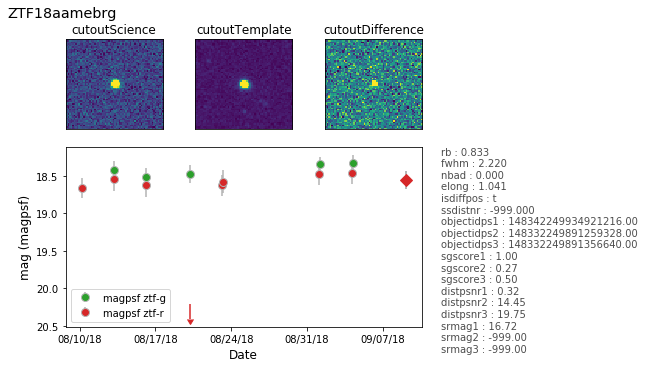

SDSS J143946.96+495805.4


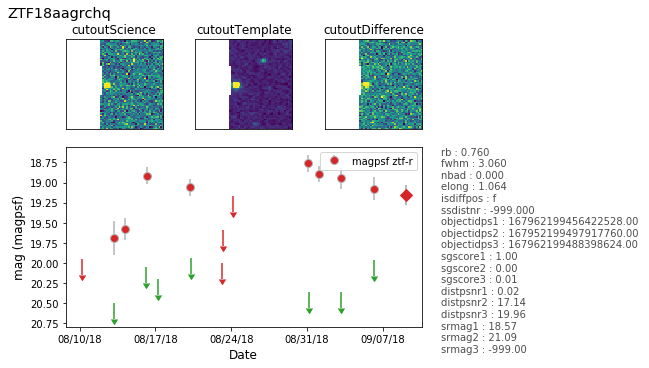

TXS 1452+516              


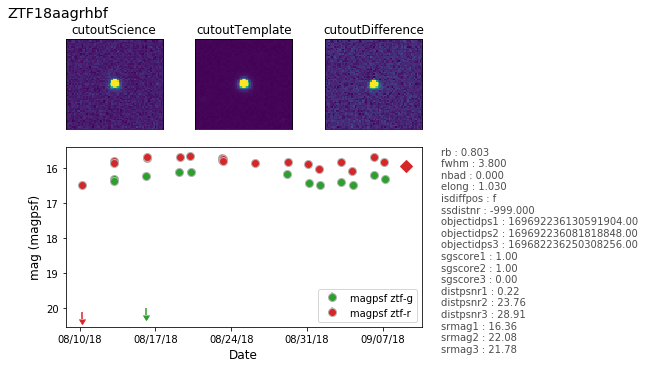

SNR G045.7-00.4           


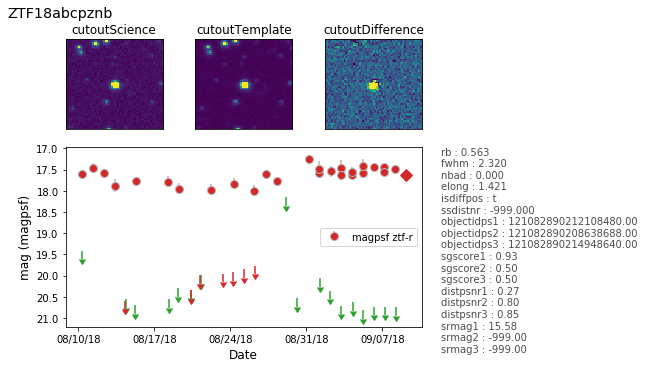

SNR G045.7-00.4           


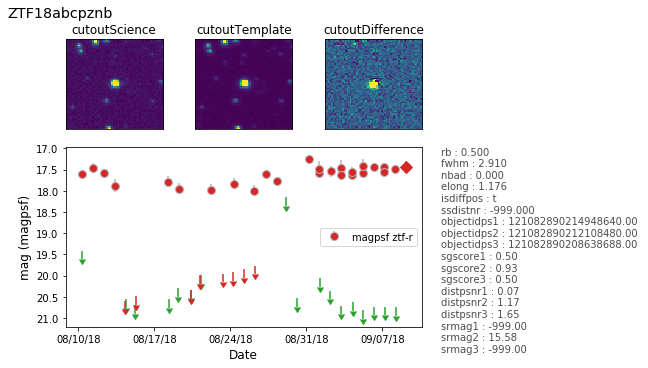

5BZBJ1836+3136


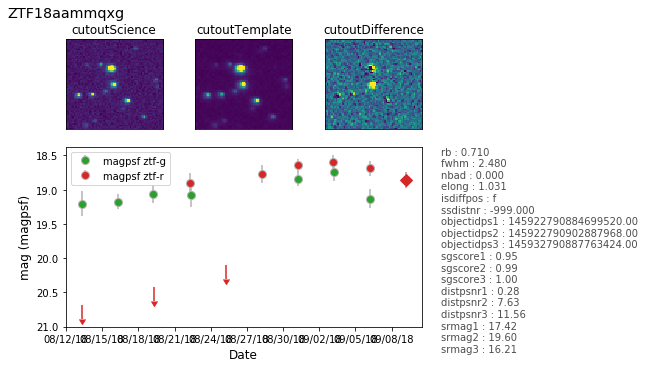

5BZQJ1848+3219


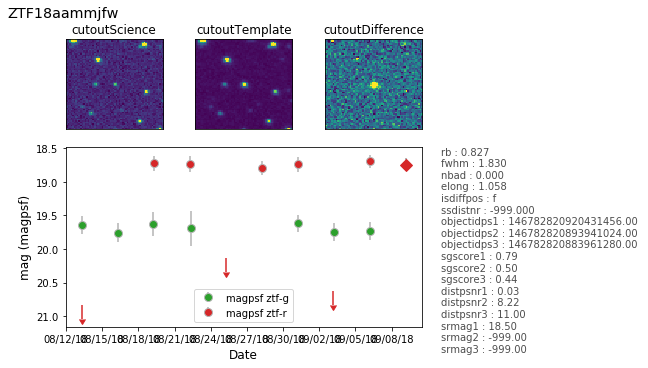

TXS 1452+516              


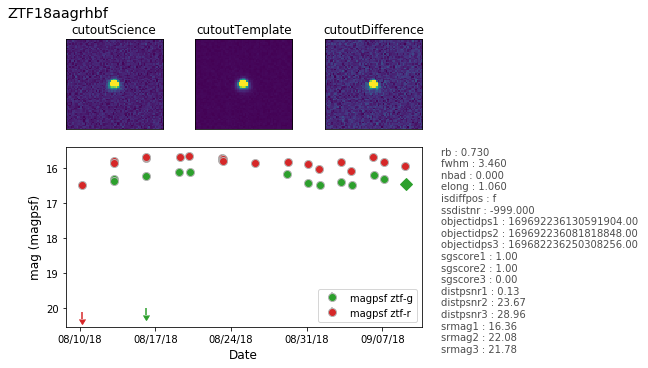

S4 1738+49                


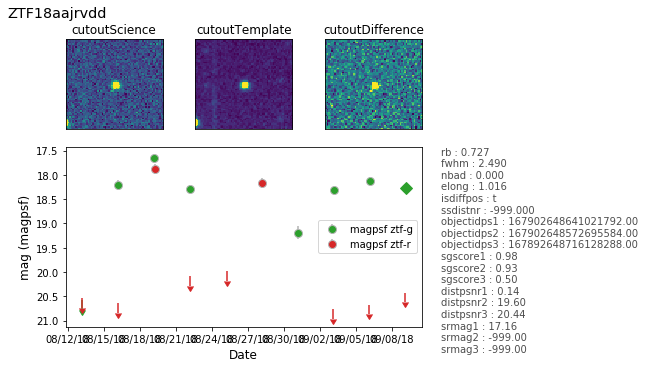

5BZGJ1730+3714


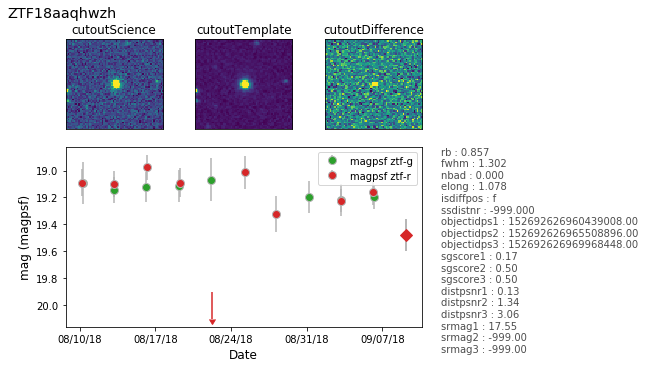

MG1 J181841+0903          


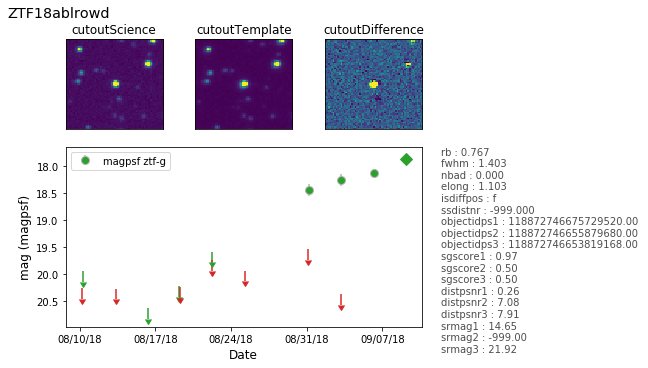

5BZQJ1801+4404


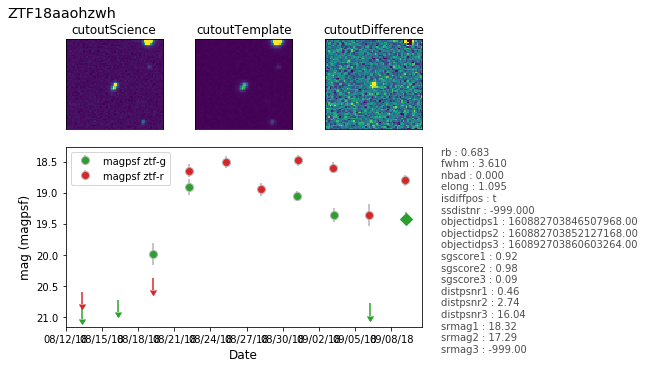

5BZQJ1459+3337


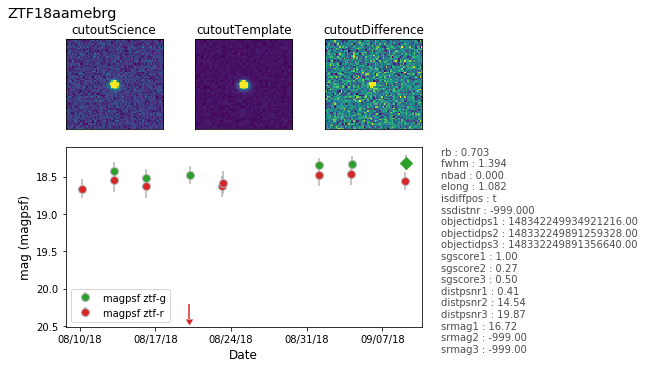

5BZUJ1706+3214


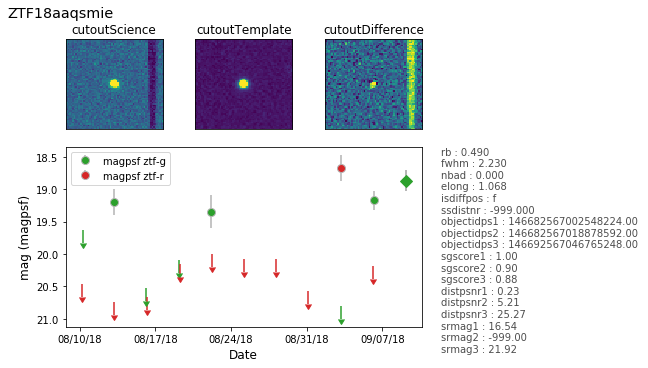

5BZQJ1801+4404


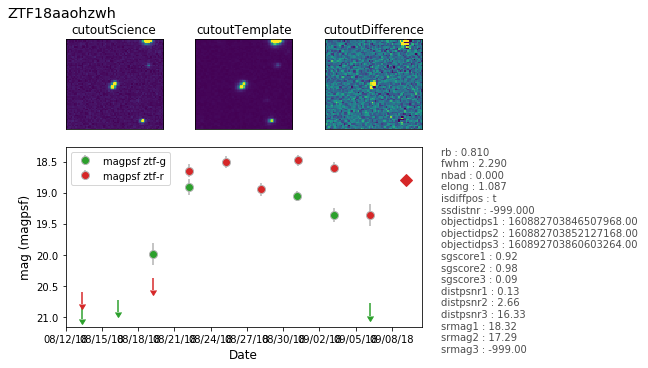

5BZGJ1730+3714


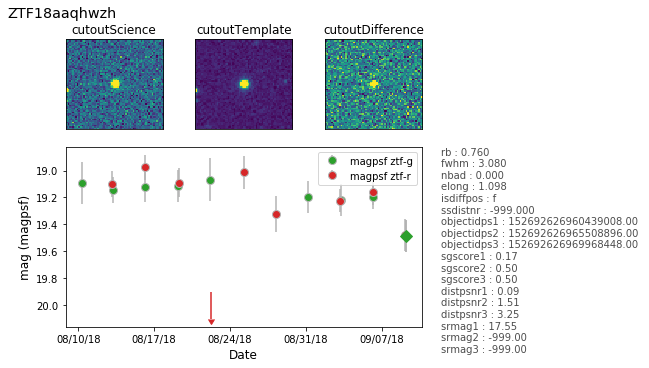

5BZQJ1801+4404


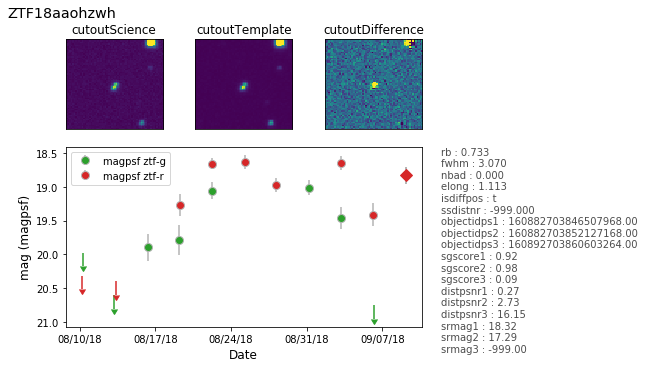

2WHSP J183849.0+480234


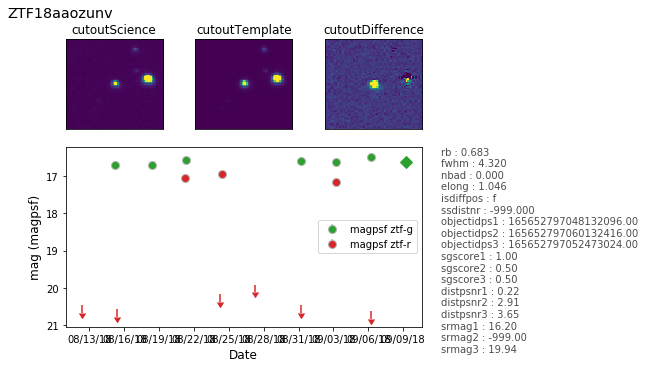

2WHSP J170238.5+311542


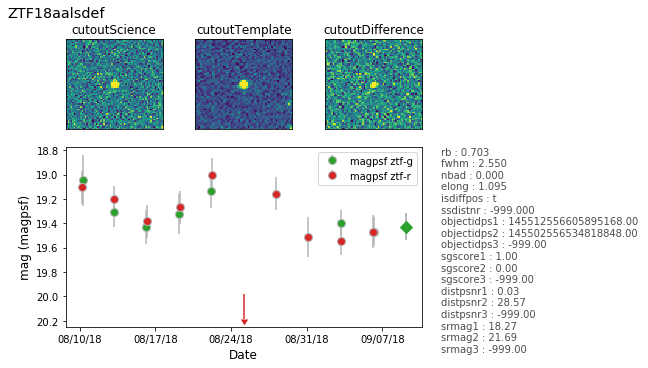

2WHSP J175949.1+703718


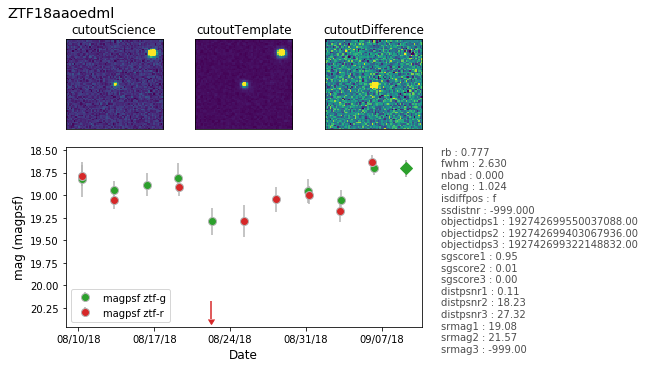

5BZBJ1836+3136


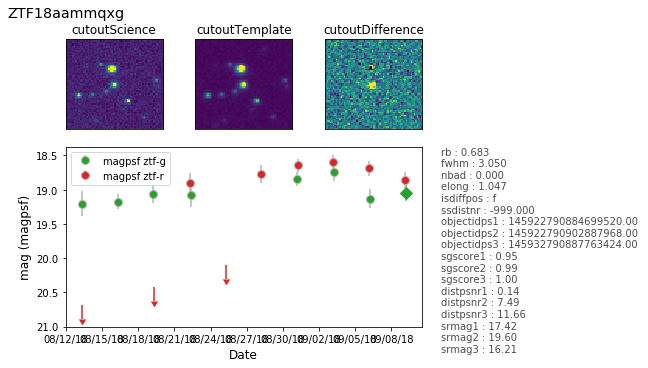

5BZQJ1801+4404


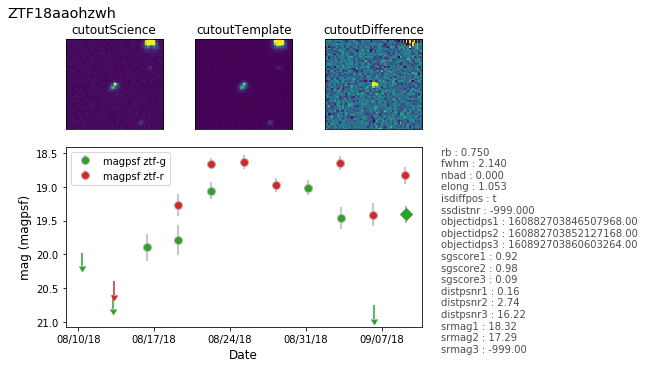

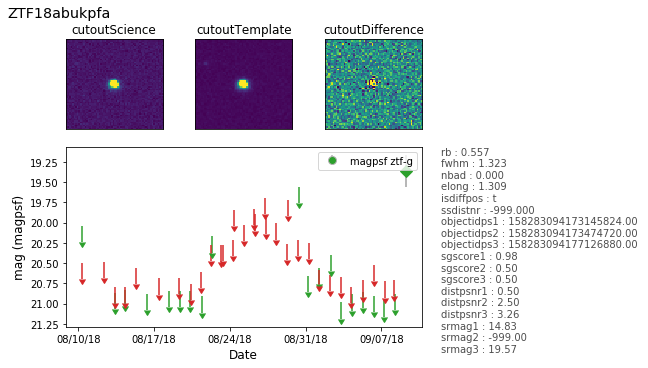

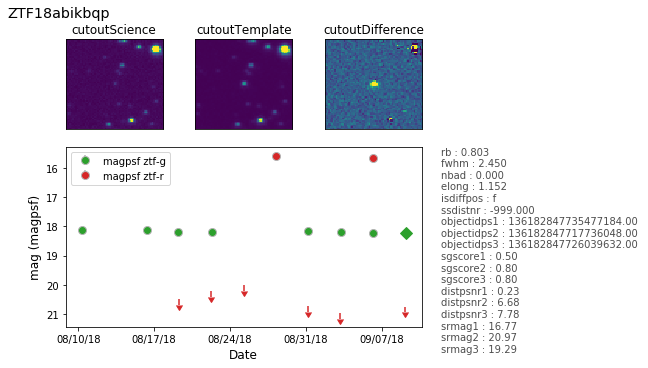

5BZQJ1854+7351


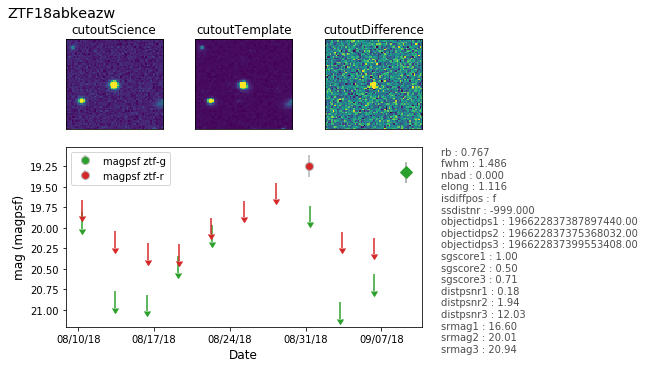

5BZQJ1716+6836


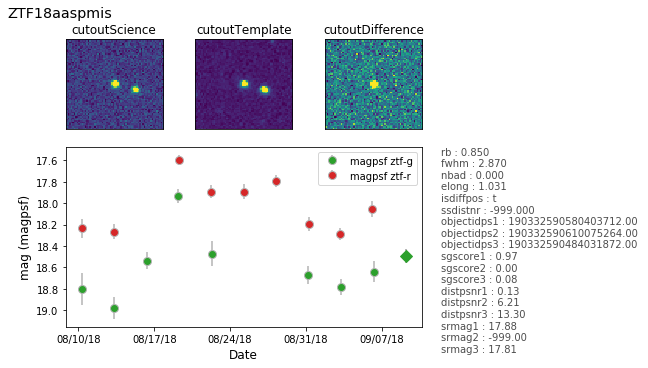

3C 371


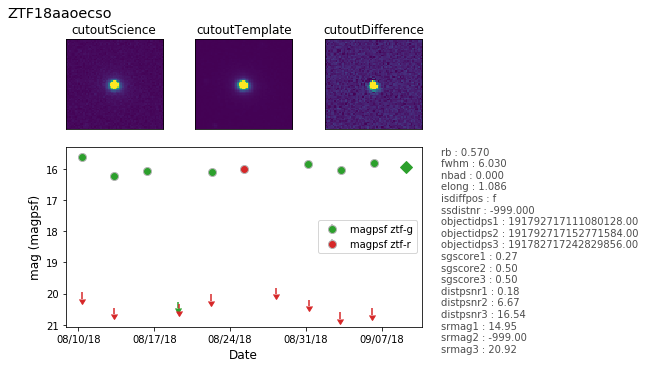

5BZQJ2211+1841


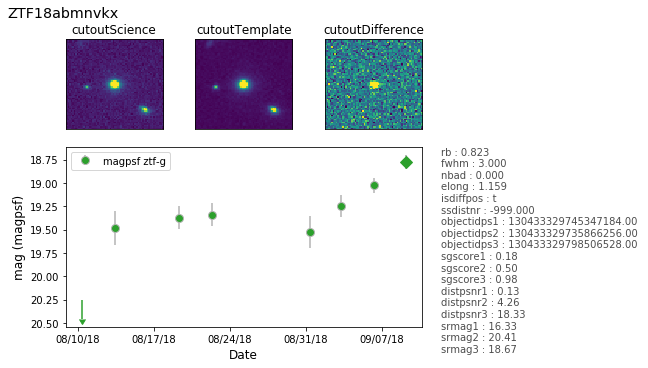

S4 1749+70                


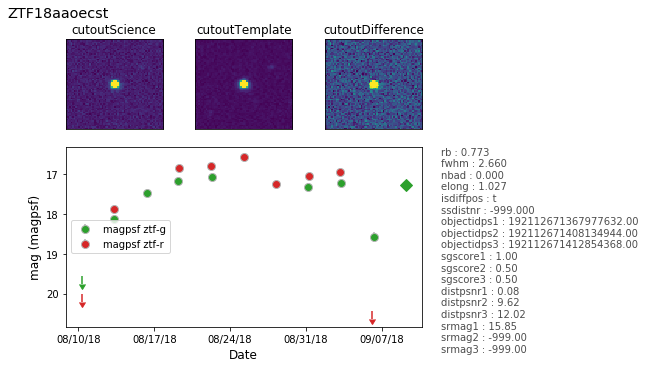

S5 2007+77                


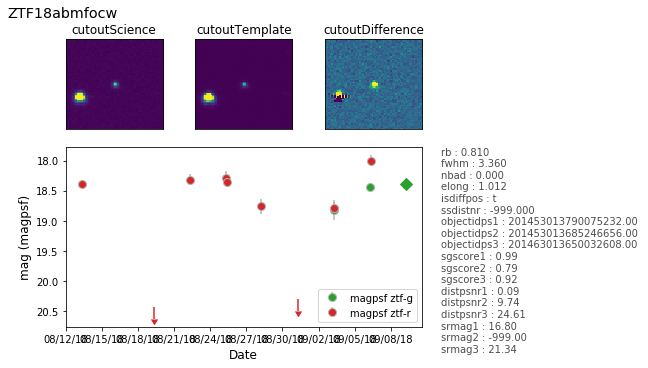

2WHSP J183849.0+480234


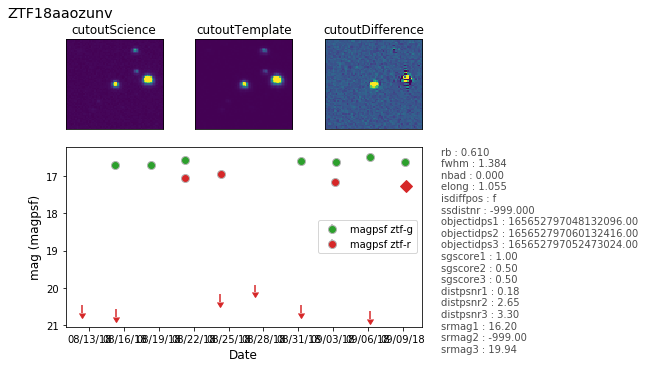

2WHSP J200112.7+435251


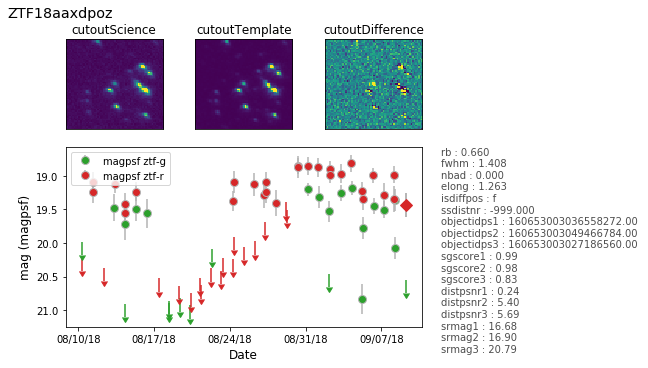

5BZBJ2346+8007


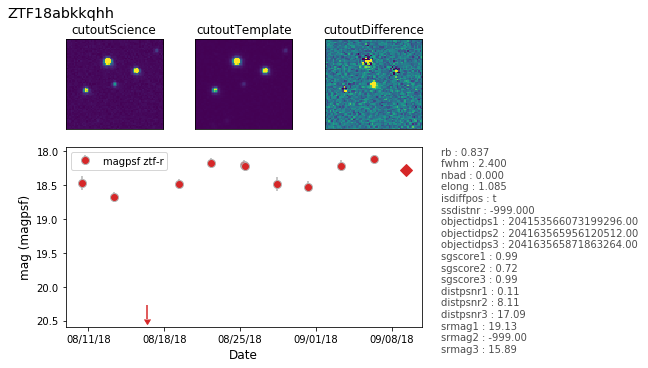

2WHSP J175949.1+703718


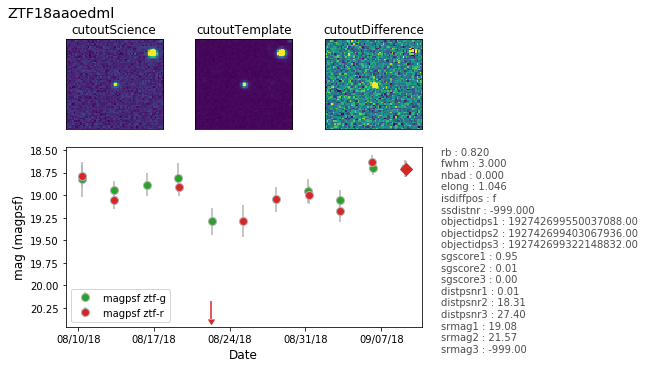

S4 1749+70                


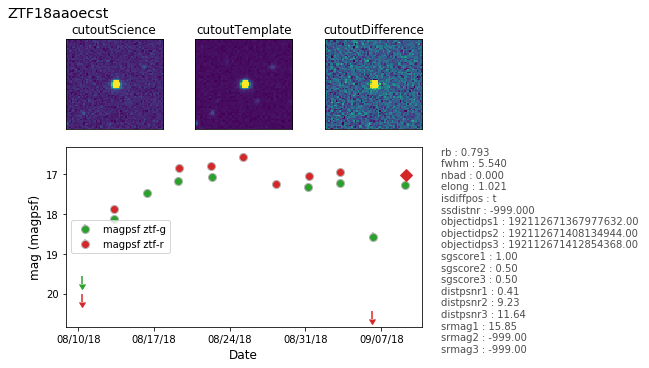

S5 2007+77                


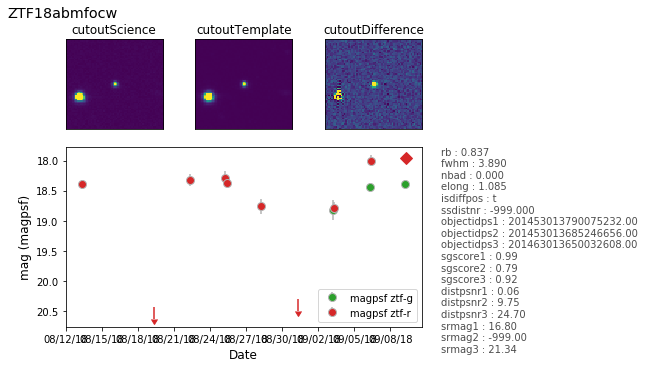

2WHSP J225005.7+382437


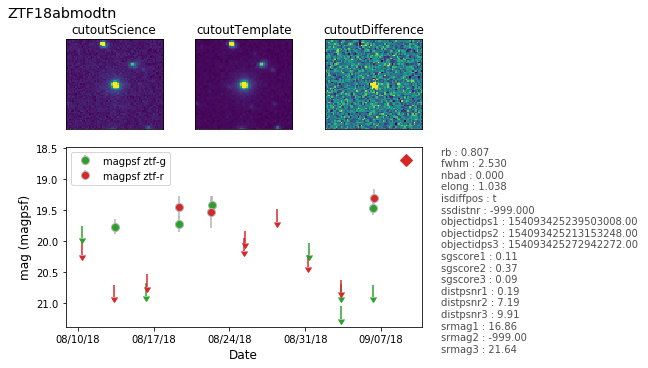

2WHSP J175713.0+703337


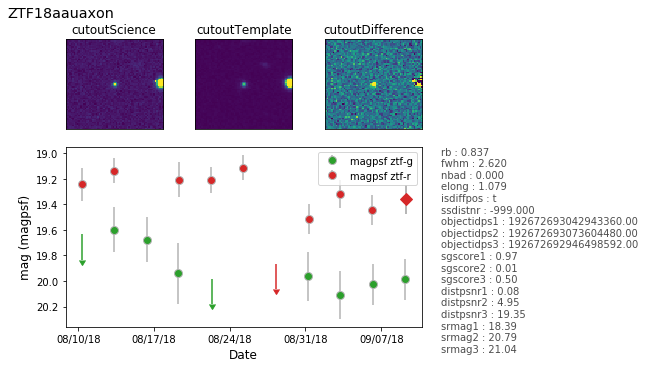

5BZQJ1854+7351


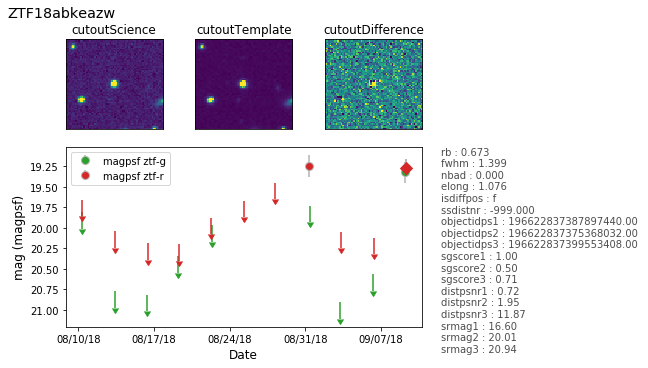

5BZQJ1716+6836


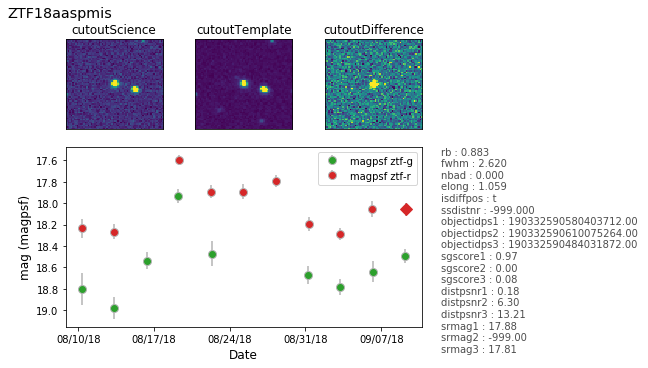

2WHSP J211243.0+081834


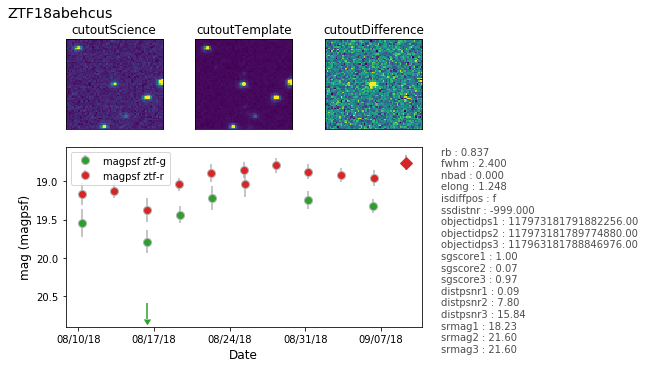

2WHSP J234704.7+514216


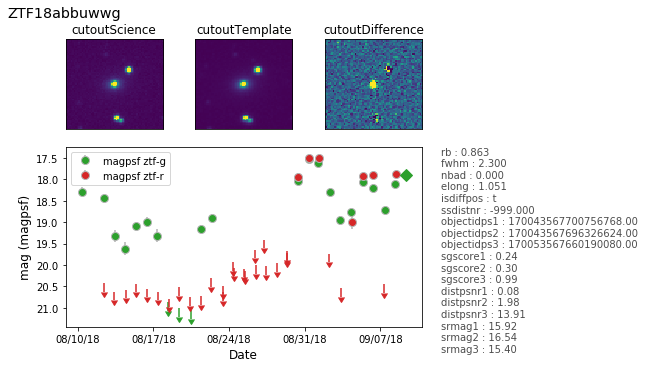

In [26]:
from ampel.view.AmpelAlertPlotter import AmpelAlertPlotter

interactive_plotter = AmpelAlertPlotter(interactive = True)

for accepted_alert in accepted:
    ismatch=None
    ra,dec=[np.mean(accepted_alert.get_values(k)) for k in ["ra","dec"]]
    for catq in my_filter.db_queries:
        matchfound = my_filter.db_queries[catq].findclosest(ra,dec,my_filter.rs_arcsec)
        if None not in matchfound:
            if 'ASSOC' in matchfound[0].columns:
                print(matchfound[0]['ASSOC'])
            elif 'ASSOC1' in matchfound[0].columns:
                print(matchfound[0]['ASSOC1'])
            break
    interactive_plotter.summary_plot(accepted_alert)

In [27]:
matchfound[0].columns

<TableColumns names=('ASSOC','DEJ2000','Dec','GAMMAASSOC','ID','RAJ2000','Redshift','_1','_10','_11','_12','_2','_3','_5','_7','_8','_9','_id','id','pos')>

In [28]:
def find_closest(array,element,maxdist=1e-1):
    array = np.asarray(array)
    k = np.argmin(np.abs(array-element))
    if np.min(np.abs(array-element)) < maxdist:
        return(k)
    else:
        #print(np.min(np.abs(array-element)))
        return(None)
    
def find_bestpairs(alerts1,alerts2,maxdist=1e-1):
    pairs1 = []
    pairs2 = []
    
    #print(alerts1)
    #print(alerts2)
    for j,element in enumerate(alerts1):
        k = find_closest(alerts2,element,maxdist)
        if k is not None:
            pairs1.append([j,k])
    
    for k,element in enumerate(alerts2):
        j = find_closest(alerts1,element,maxdist)
        if j is not None:
            pairs2.append([j,k])
    
    pairs = np.asarray([k for k in pairs1 if k in pairs2])
    return(pairs)

def get_color_alert(alert):
    filt_g = np.asarray(['_zg_' in p['pdiffimfilename'] for p in alert])
    filt_r = np.asarray(['_zr_' in p['pdiffimfilename'] for p in alert])
    jds = np.asarray([p['jd'] for p in alert])-2400000.5
    mag = np.asarray([p['magpsf'] for p in alert])
    magerr = np.asarray([p['sigmapsf'] for p in alert])
    pairs = find_bestpairs(jds[filt_g],jds[filt_r])
    #print(pairs)
    
    g = mag[filt_g]
    r = mag[filt_r]
    gerr = magerr[filt_g]
    rerr = magerr[filt_r]
    
    color   = [g[k[0]]-r[k[1]] for k in pairs]
    jdcolor = [0.5*(jds[filt_g][k[0]]+jds[filt_r][k[1]]) for k in pairs]
    colorerr = [np.sqrt(gerr[k[0]]**2 + rerr[k[1]]**2) for k in pairs]
    
    alertdict = {}
    alertdict['jd'] = jdcolor
    alertdict['color'] = color
    alertdict['colorerr'] = colorerr
    return(alertdict)

In [31]:
ps = accepted_alert.get_photopoints()
ra = np.asarray([p['ra'] for p in ps])
dec = np.asarray([p['dec'] for p in ps])
filt_g = np.asarray(['_zg_' in p['pdiffimfilename'] for p in ps])
filt_r = np.asarray(['_zr_' in p['pdiffimfilename'] for p in ps])
jds = np.asarray([p['jd'] for p in ps])-2400000.5
mag = np.asarray([p['magpsf'] for p in ps])
magerr = np.asarray([p['sigmapsf'] for p in ps])

pairs = 0

In [32]:
?accepted_alert.tran_id

In [33]:
alertdict=get_color_alert(ps)

In [34]:
alertdict

{'jd': [58360.37333335006,
  58361.36618629983,
  58362.30000000005,
  58365.32276619994,
  58366.37617475004,
  58367.32556715002,
  58369.364849550184],
 'color': [0.11300086975097656,
  0.0334014892578125,
  0.1364002227783203,
  -0.25150108337402344,
  0.1448993682861328,
  0.29199981689453125,
  0.22900009155273438],
 'colorerr': [0.11725491868157682,
  0.07841347357968446,
  0.08624242935766159,
  0.1638173692356904,
  0.07866143056692118,
  0.1079390442658658,
  0.09877661218933806]}

In [35]:
mag

array([17.89262581, 18.28380013, 18.44350052, 19.31669998, 19.62120056,
       19.0984993 , 18.98970032, 19.31159973, 19.1534996 , 18.90629959,
       17.93309975, 18.04610062, 17.49939919, 17.53280067, 17.62619972,
       17.4897995 , 18.28409958, 18.95330048, 18.75359917, 19.00510025,
       17.9151001 , 18.05999947, 18.19269943, 17.90069962, 18.71579933,
       18.11090088, 17.88190079])

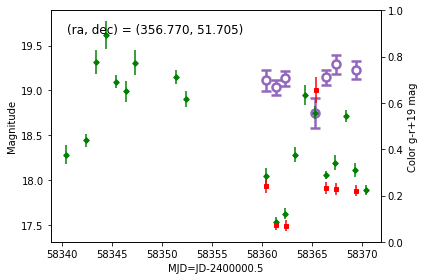

In [36]:
plt.errorbar(x=jds[filt_g],y=mag[filt_g],yerr=magerr[filt_g],ls='',marker='D',capsize=0,ms=4, color='g')
plt.errorbar(x=jds[filt_r],y=mag[filt_r],yerr=magerr[filt_r],ls='',marker='s',capsize=0,ms=4, color='r')
plt.errorbar(x=alertdict['jd'],y=np.asarray(alertdict['color'])+19,yerr=alertdict['colorerr'],
             marker='o',mfc='white',mec='C4',color='C4',ms=8,lw=2.5,mew=2.5,ls='',capsize=5,zorder=-4)
plt.ylabel('Magnitude')
plt.xlabel('MJD=JD-2400000.5')

ax2 = plt.twinx()
ax2.set_ylabel('Color g-r+19 mag')
plt.annotate(s=str("(ra, dec) = (%.3f, %.3f)" %(ra[0],dec[0])),xy=[0.05,0.9],
             xycoords='axes fraction',fontsize='large')
plt.tight_layout()
plt.savefig("/home/mnievas/test.png")

In [37]:
?plt.annotate()